In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
ice_df = pd.read_csv("CO2 Emissions_vehicle.csv")
ev_df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

print("ICE dataset:", ice_df.shape)
print("EV dataset:", ev_df.shape)


ICE dataset: (7385, 12)
EV dataset: (270262, 16)


In [3]:
ice_df = ice_df[[
    "Engine Size(L)",
    "Fuel Type",
    "Fuel Consumption Comb (L/100 km)",
    "CO2 Emissions(g/km)"
]]

ice_df.columns = [
    "engine_size",
    "fuel_type",
    "fuel_consumption",
    "co2_emissions"
]

ice_df["vehicle_type"] = "ICE"

ice_df.fillna(ice_df.median(numeric_only=True), inplace=True)

In [4]:
ev_clean = pd.DataFrame()

ev_clean["engine_size"] = 0
ev_clean["fuel_type"] = "Electric"
ev_clean["fuel_consumption"] = ev_df["Electric Range"].fillna(ev_df["Electric Range"].median())
ev_clean["co2_emissions"] = 0
ev_clean["vehicle_type"] = "EV"

In [5]:
df = pd.concat([ice_df, ev_clean], ignore_index=True)
print("Combined dataset:", df.shape)

Combined dataset: (277647, 5)


In [6]:
df

,engine_size,fuel_type,fuel_consumption,co2_emissions,vehicle_type
0,2.0,Z,8.5,196,ICE
1,2.4,Z,9.6,221,ICE
2,1.5,Z,5.9,136,ICE
3,3.5,Z,11.1,255,ICE
4,3.5,Z,10.6,244,ICE
...,...,...,...,...,...
277642,NaN,NaN,21.0,0,EV
277643,NaN,NaN,22.0,0,EV
277644,NaN,NaN,0.0,0,EV
277645,NaN,NaN,0.0,0,EV


In [7]:
df = pd.read_csv("vehicle_emissions_final_cleaned4.csv")
df.head()

,engine_size,fuel_type,fuel_consumption,co2_emissions,vehicle_type
0,2.0,Z,8.5,196,ICE
1,2.4,Z,9.6,221,ICE
2,1.5,Z,5.9,136,ICE
3,3.5,Z,11.1,255,ICE
4,3.5,Z,10.6,244,ICE


In [8]:
# EVs do not have engines → set engine_size & fuel_consumption to 0
df.loc[df["vehicle_type"] == "EV", "engine_size"] = 0
df.loc[df["vehicle_type"] == "EV", "fuel_consumption"] = 0

# Quick verification
df.groupby("vehicle_type")[["engine_size", "fuel_consumption"]].mean()

,engine_size,fuel_consumption
vehicle_type,,
EV,0.000000,0.000000
ICE,3.160068,10.975071


In [9]:
ice_df = df[df["vehicle_type"] == "ICE"].copy()

ice_df[["engine_size", "fuel_consumption", "co2_emissions"]].describe()

,engine_size,fuel_consumption,co2_emissions
count,7385.000000,7385.000000,7385.000000
mean,3.160068,10.975071,250.584699
std,1.354170,2.892506,58.512679
min,0.900000,4.100000,96.000000
25%,2.000000,8.900000,208.000000
50%,3.000000,10.600000,246.000000
75%,3.700000,12.600000,288.000000
max,8.400000,26.100000,522.000000


In [10]:
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

ice_df = remove_outliers_iqr(
    ice_df, ["engine_size", "fuel_consumption", "co2_emissions"]
)


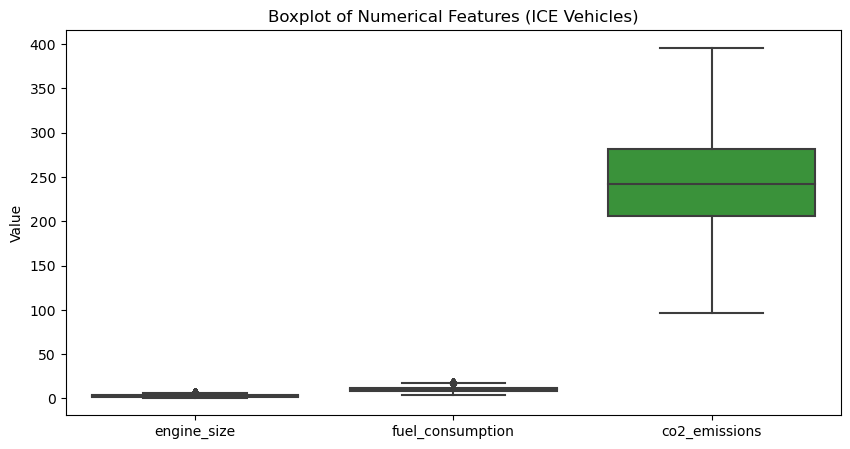

In [11]:
numerical_cols = ["engine_size", "fuel_consumption", "co2_emissions"]

plt.figure(figsize=(10, 5))
sns.boxplot(data=ice_df[numerical_cols])
plt.title("Boxplot of Numerical Features (ICE Vehicles)")
plt.ylabel("Value")
plt.show()

In [12]:
df.isnull().sum()

engine_size         0
fuel_type           0
fuel_consumption    0
co2_emissions       0
vehicle_type        0
dtype: int64

In [13]:
# Replace missing fuel_type with 'Electric' for EV rows
df.loc[df["vehicle_type"] == "EV", "fuel_type"] = "Electric"

# Verify
df.isnull().sum()

engine_size         0
fuel_type           0
fuel_consumption    0
co2_emissions       0
vehicle_type        0
dtype: int64

In [14]:
# Save final cleaned combined dataset
df.to_csv("vehicle_emissions_final_cleaned4.csv", index=False)

print("✅ Final combined dataset saved as vehicle_emissions_final_cleaned.csv")

✅ Final combined dataset saved as vehicle_emissions_final_cleaned.csv


In [15]:
df.head()

,engine_size,fuel_type,fuel_consumption,co2_emissions,vehicle_type
0,2.0,Z,8.5,196,ICE
1,2.4,Z,9.6,221,ICE
2,1.5,Z,5.9,136,ICE
3,3.5,Z,11.1,255,ICE
4,3.5,Z,10.6,244,ICE


In [16]:
df.tail()

,engine_size,fuel_type,fuel_consumption,co2_emissions,vehicle_type
277642,0.0,Electric,0.0,0,EV
277643,0.0,Electric,0.0,0,EV
277644,0.0,Electric,0.0,0,EV
277645,0.0,Electric,0.0,0,EV
277646,0.0,Electric,0.0,0,EV


In [17]:
df.describe()

,engine_size,fuel_consumption,co2_emissions
count,277647.000000,277647.000000,277647.000000
mean,0.084053,0.291921,6.665183
std,0.554364,1.827882,41.434626
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,8.400000,26.100000,522.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277647 entries, 0 to 277646
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   engine_size       277647 non-null  float64
 1   fuel_type         277647 non-null  object 
 2   fuel_consumption  277647 non-null  float64
 3   co2_emissions     277647 non-null  int64  
 4   vehicle_type      277647 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 10.6+ MB


In [19]:
print(df.dtypes)

engine_size         float64
fuel_type            object
fuel_consumption    float64
co2_emissions         int64
vehicle_type         object
dtype: object


In [20]:
from sklearn.preprocessing import LabelEncoder
le_fuel = LabelEncoder()
le_vehicle = LabelEncoder()

df["fuel_type_encoded"] = le_fuel.fit_transform(df["fuel_type"])
df["vehicle_type_encoded"] = le_vehicle.fit_transform(df["vehicle_type"])


In [21]:
df_encoded = df.drop(columns=["fuel_type", "vehicle_type"])


In [22]:
df_encoded.dtypes


engine_size             float64
fuel_consumption        float64
co2_emissions             int64
fuel_type_encoded         int32
vehicle_type_encoded      int32
dtype: object

In [23]:
df_encoded.head()

,engine_size,fuel_consumption,co2_emissions,fuel_type_encoded,vehicle_type_encoded
0,2.0,8.5,196,5,1
1,2.4,9.6,221,5,1
2,1.5,5.9,136,5,1
3,3.5,11.1,255,5,1
4,3.5,10.6,244,5,1


In [24]:
model_df = df[df["vehicle_type"] == "ICE"].copy()

print("ICE rows:", model_df.shape[0])

ICE rows: 7385


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

In [26]:
X = model_df[[
    "engine_size",
    "fuel_consumption"
]].copy()

y = model_df["co2_emissions"]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

In [29]:
y_pred = lin_model.predict(X_test)

In [30]:
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)*100
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 443.2432335455481
R-squared: 87.11362656104268


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
ran_model = RandomForestRegressor()
ran_model.fit(X_train,y_train)

RandomForestRegressor()

In [34]:
y_pred = ran_model.predict(X_test)

In [35]:
r2 = r2_score(y_test, y_pred)*100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [36]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 116.17174741133496
R-squared: 96.62254850858349


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dec_model = DecisionTreeRegressor()
dec_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [38]:
y_pred = dec_model.predict(X_test)

In [39]:
r2 = r2_score(y_test, y_pred)*100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [40]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 142.92680615294043
R-squared: 95.84470092461098


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [42]:
y_pred = knn_model.predict(X_test)

In [43]:
r2 = r2_score(y_test, y_pred)*100
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [44]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 146.9404468517265
R-squared: 95.72801268443047


In [45]:
# Linear Regression
lin_y_pred = lin_model.predict(X_test)
lin_r2_score = r2_score(y_test, lin_y_pred)

# Random Forest
rf_y_pred = ran_model.predict(X_test)
rf_r2_score = r2_score(y_test, rf_y_pred)

# Decision Tree
dec_y_pred = dec_model.predict(X_test)
dec_r2_score = r2_score(y_test, dec_y_pred)

# KNN
knn_y_pred = knn_model.predict(X_test)
knn_r2_score = r2_score(y_test, knn_y_pred)



In [46]:
data = {
    "Model": ["Linear Regression", "Random Forest", "Decision Tree", "KNN"],
    "R2 Score": [lin_r2_score, rf_r2_score, dec_r2_score, knn_r2_score]
}

df = pd.DataFrame(data)
df


,Model,R2 Score
0,Linear Regression,0.871136
1,Random Forest,0.966225
2,Decision Tree,0.958447
3,KNN,0.957280


In [47]:
df.sort_values(by="R2 Score", ascending=False)

,Model,R2 Score
1,Random Forest,0.966225
2,Decision Tree,0.958447
3,KNN,0.957280
0,Linear Regression,0.871136


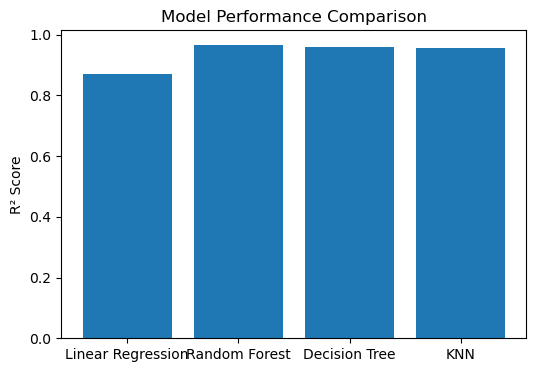

In [48]:
plt.figure(figsize=(6,4))
plt.bar(df["Model"], df["R2 Score"])
plt.ylabel("R² Score")
plt.title("Model Performance Comparison")
plt.show()


In [49]:
final_model = RandomForestRegressor(random_state=42)

final_model.fit(X_train, y_train)

y_pred_final = final_model.predict(X_test)

print("Final Model R²:", r2_score(y_test, y_pred_final))



Final Model R²: 0.9668502195244061


In [50]:
import joblib

# Create model
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

# Train model
model.fit(X, y)

# Save model
joblib.dump(model, "vehicle_co2_model.pkl")

print(" Model retrained and saved successfully")


 Model retrained and saved successfully


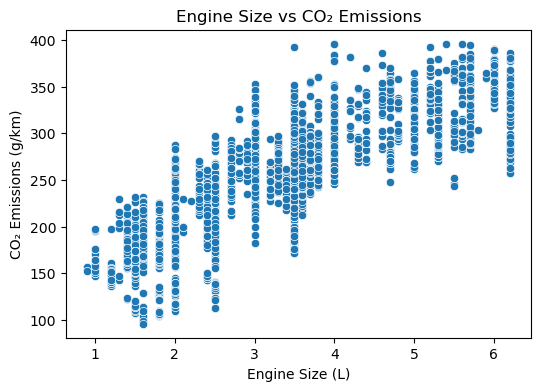

In [51]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="engine_size",
    y="co2_emissions",
    data=ice_df
)
plt.title("Engine Size vs CO₂ Emissions")
plt.xlabel("Engine Size (L)")
plt.ylabel("CO₂ Emissions (g/km)")
plt.show()


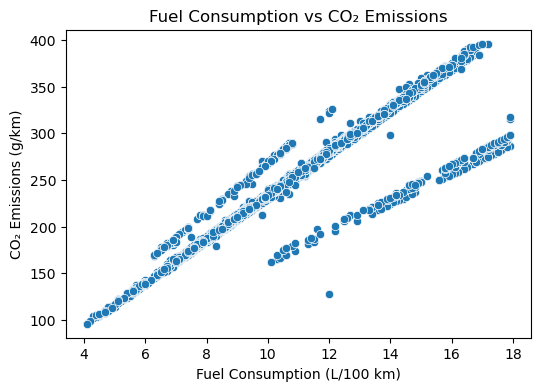

In [52]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x="fuel_consumption",
    y="co2_emissions",
    data=ice_df
)
plt.title("Fuel Consumption vs CO₂ Emissions")
plt.xlabel("Fuel Consumption (L/100 km)")
plt.ylabel("CO₂ Emissions (g/km)")
plt.show()

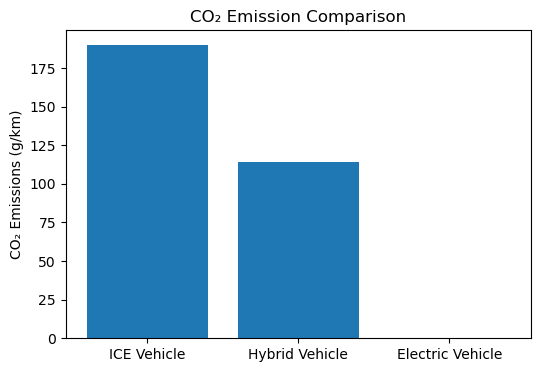

In [55]:


# Example values (use your predicted values here)
ice_co2 = 190      # g/km (from ML)
hybrid_co2 = ice_co2 * 0.6
ev_co2 = 0

comparison_df = pd.DataFrame({
    "Vehicle Type": ["ICE Vehicle", "Hybrid Vehicle", "Electric Vehicle"],
    "CO₂ Emissions (g/km)": [ice_co2, hybrid_co2, ev_co2]
})

plt.figure(figsize=(6,4))
plt.bar(
    comparison_df["Vehicle Type"],
    comparison_df["CO₂ Emissions (g/km)"]
)
plt.ylabel("CO₂ Emissions (g/km)")
plt.title("CO₂ Emission Comparison")
plt.show()


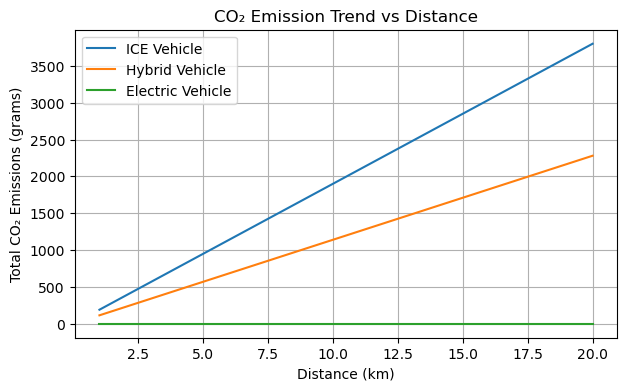

In [56]:
distance = 20  # km
distances = np.arange(1, distance + 1)

# Per-km emissions
ice_per_km = ice_co2
hybrid_per_km = hybrid_co2
ev_per_km = ev_co2

plt.figure(figsize=(7,4))
plt.plot(distances, ice_per_km * distances, label="ICE Vehicle")
plt.plot(distances, hybrid_per_km * distances, label="Hybrid Vehicle")
plt.plot(distances, ev_per_km * distances, label="Electric Vehicle")

plt.xlabel("Distance (km)")
plt.ylabel("Total CO₂ Emissions (grams)")
plt.title("CO₂ Emission Trend vs Distance")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
sample_input = np.array([[2.0, 8.5]])  # engine_size, fuel_consumption
prediction = final_model.predict(sample_input)

print("Predicted CO₂:", prediction[0], "g/km")


Predicted CO₂: 199.1270880542336 g/km
